# RNN레이어를 사용한 순환신경망
- 기존의 선형변환(임베딩 레이어, Linear 레이어)는 과거의 데이터를 사용하지 못해서 AbAcAd와 같은 예제를 해결하지 못함
- RNN이나 LSTM과 같은 레이어를 사용하면 위와 같은 예제를 해결할 수 있음

In [105]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

`-` optimizer에 입력하는 network.parameters()
- network.parameters()자리에는 iterable object를 입력해야 함
- 대표적인 iterable object는 리스트가 있음
- 만약 optimizer를 사용해 2개 이상의 값들을 업데이트하고 싶다면 이들을 리스트로 묶어서 network.parameters() 자리에 입력을 해주면 됨

## RNNcell을 사용해 AbAcAd 예제 해결하기

In [106]:
txt = list('AbAcAd')*100
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [107]:
txt_x = txt[:-1]
txt_y = txt[1:]

x = torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))

In [108]:
x= torch.nn.functional.one_hot(x).float()
y= torch.nn.functional.one_hot(y).float()

In [109]:
x

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])

- RNN의 원리를 수식으로 설명하면 아래와 같다.
 
$h_t = tanh(x_{input}W_{ih} + h_{t-1}W_{hh} + bias_h)$ *(여기에서 $h_{t-1}$은 과거의 데이터를 의미한다)*

$output = W_{ho}h_t + bias_o$

$yhat = softmax(output)$

- $h_1$의 경우에는 과거의 데이터가 없으므로 처음 시작할 때는 0으로 만들어진 $h_t$를 만들어줘야 함

### 순환 신경망 학습시키기
- 위의 수식대로 순환신경망 정의하기

In [110]:
torch.manual_seed(43052)

rnncell = torch.nn.RNNCell(4, 2)

In [111]:
torch.manual_seed(43052)

Lin = torch.nn.Linear(2, 4)

loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(list(rnncell.parameters())+list(Lin.parameters()))

In [112]:
T = len(x)
for epoch in tqdm(range(5000)):
    loss = 0
    ht = torch.zeros(1,2)

    for t in range(T):
        xt, yt = x[[t]], y[[t]]
        ht = rnncell(xt, ht)
        ot = Lin(ht)

        loss = loss + loss_fn(ot, yt)

    loss.backward()

    optim.step()
    optim.zero_grad()

100%|██████████| 5000/5000 [13:40<00:00,  6.10it/s]


In [113]:
hidden = torch.zeros(T, 2)
_water = torch.zeros(1,2)

hidden[[0]] = rnncell(x[[0]], _water)

for t in range(1, T):
    hidden[[t]] = rnncell(x[[t]], hidden[[t-1]])


In [114]:
hidden

tensor([[-0.9912, -0.9117],
        [ 0.0698, -1.0000],
        [-0.9927, -0.9682],
        ...,
        [-0.9935, -0.9315],
        [ 0.5777, -1.0000],
        [-0.9960, -0.0109]], grad_fn=<IndexPutBackward0>)

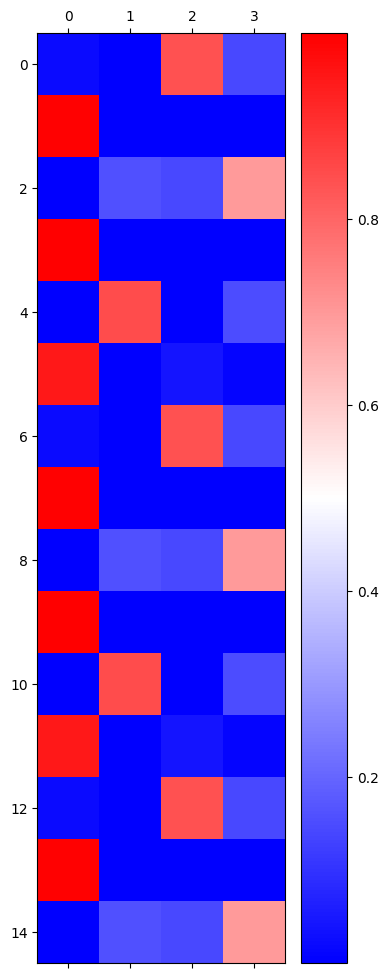

In [115]:
yhat = soft(Lin(hidden))

plt.matshow(yhat[-15:].data, cmap ='bwr')
plt.colorbar()

## RNN과 RNNcell의 차이점

In [116]:
rnn = torch.nn.RNN(4, 2)

In [117]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data

In [118]:
_water = torch.zeros(1, 2)
rnncell(x,_water)

RuntimeError: Input batch size 599 doesn't match hidden0 batch size 1

- RNNcell은 위와 같이 입력을 주면 에러가 발생함

```python
for t in range(T):
    xt, yt = x[[t]], y[[t]]
    ht = rnncell(xt, ht)
    ot = Lin(ht)
```

- 그렇기 때문에 위와 같은 방식으로 학습을 시켜야 함


In [119]:
_water = torch.zeros(1, 2)
rnn(x,_water)

(tensor([[-0.9912, -0.9117],
         [ 0.0698, -1.0000],
         [-0.9927, -0.9682],
         ...,
         [-0.9935, -0.9315],
         [ 0.5777, -1.0000],
         [-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>))

- 하지만 RNN은 for문 안에 넣을 필요없이 한번에 연산이 가능함
- 같은 weight와 bias를 사용하지만 편의성(?)측면에서 RNN이 좋음

## RNN을 사용해 AbAcAd 예제 해결하기 (히든 노드 2개)

In [120]:
rnn = torch.nn.RNN(4,2).to('cuda:0')

In [121]:
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(4, 2).to('cuda:0')

rnn.weight_hh_l0.data = _rnncell.weight_hh.data 
rnn.weight_ih_l0.data = _rnncell.weight_ih.data
rnn.bias_hh_l0.data = _rnncell.bias_hh.data
rnn.bias_ih_l0.data = _rnncell.bias_ih.data

In [122]:
torch.manual_seed(43052)
Lin = torch.nn.Linear(2, 4).to('cuda:0')

In [123]:
loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(list(rnn.parameters()) + list(Lin.parameters()))

In [124]:
_water = torch.zeros(1,2).to('cuda:0')

for epoch in tqdm(range(5000)):
    hidden, ht = rnn(x.to('cuda:0'), _water)
    output = Lin(hidden)
    
    loss = loss_fn(output, y.to('cuda:0'))

    loss.backward()

    optim.step()
    optim.zero_grad()

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\default.DESKTOP-HUJV032\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:476: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|██████████| 5000/5000 [00:23<00:00, 215.98it/s]


`-` rnn을 실행하면 2개가 출력되는데 이는 hidden과 ht이다
- hidden은 x를 계산한 모든 값들이 출력된다
- ht는 마지막의 값만 저장되어있는데 이는 ht값들이 쌓여서 hidden을 만든다고 생각하면 된다.
- 그렇기 때문에 hidden을 사용해 loss를 계산하여야 한다.

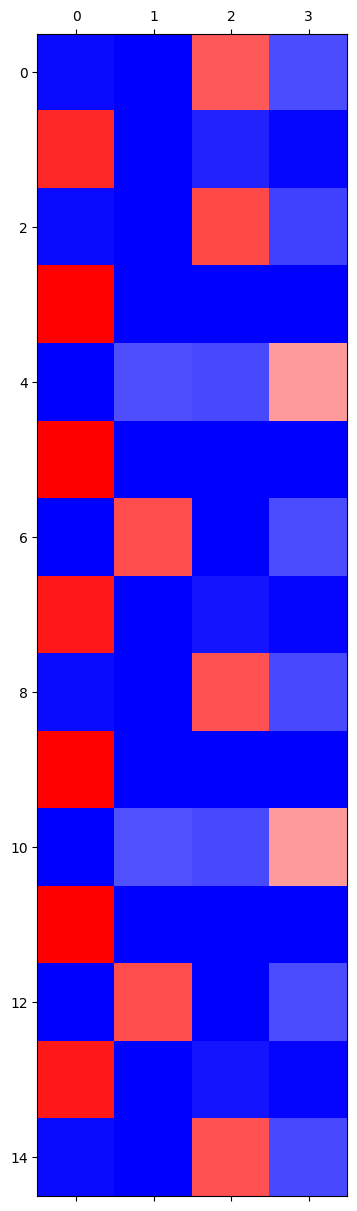

In [125]:
yhat = soft(output)

plt.matshow(yhat.data[:15].to('cpu'), cmap = 'bwr')

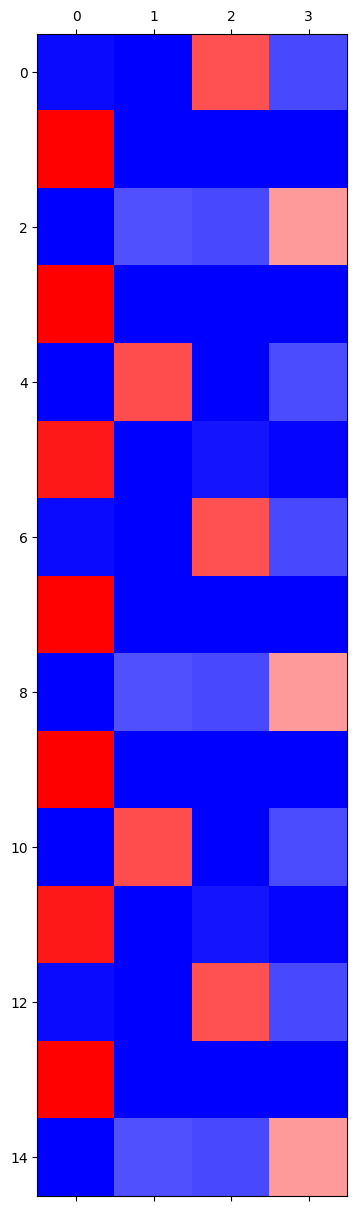

In [126]:
plt.matshow(yhat.data[-15:].to('cpu'), cmap = 'bwr')

- 초반에는 예측을 틀리지만 마지막에서는 완벽한 성능을 보여줌

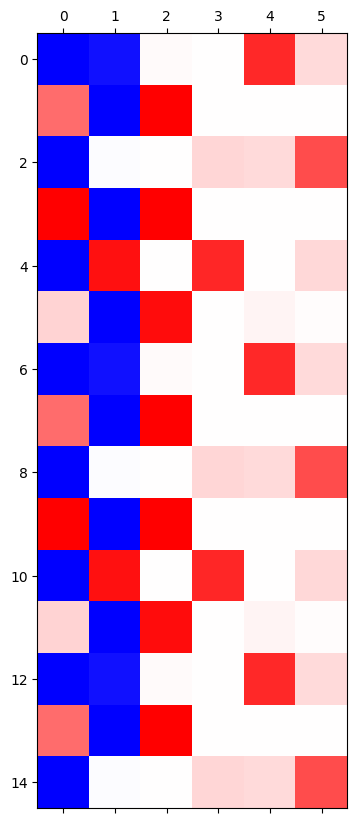

In [127]:
combined = torch.concat([hidden, yhat], axis = 1)
plt.matshow(combined[-15:].data.to('cpu'),cmap='bwr')

## RNN을 사용해 AbAcAd 예제 해결하기 (히든 노드 3개)

In [128]:
x = x.to('cuda:0')
y = y.to('cuda:0')

In [129]:
torch.manual_seed(43052)
rnn = torch.nn.RNN(4,3).to('cuda:0')
Lin = torch.nn.Linear(3, 4).to('cuda:0')

In [130]:
loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(list(rnn.parameters()) + list(Lin.parameters()))

In [131]:
_water = torch.zeros(1,3).to('cuda:0')

for epoch in tqdm(range(5000)):
    hidden, ht = rnn(x, _water)
    output = Lin(hidden)
    
    loss = loss_fn(output, y)

    loss.backward()

    optim.step()
    optim.zero_grad()

100%|██████████| 5000/5000 [00:20<00:00, 245.12it/s]


`-` rnn을 실행하면 2개가 출력되는데 이는 hidden과 ht이다
- hidden은 x를 계산한 모든 값들이 출력된다
- ht는 마지막의 값만 저장되어있는데 이는 ht값들이 쌓여서 hidden을 만든다고 생각하면 된다.
- 그렇기 때문에 hidden을 사용해 loss를 계산하여야 한다.

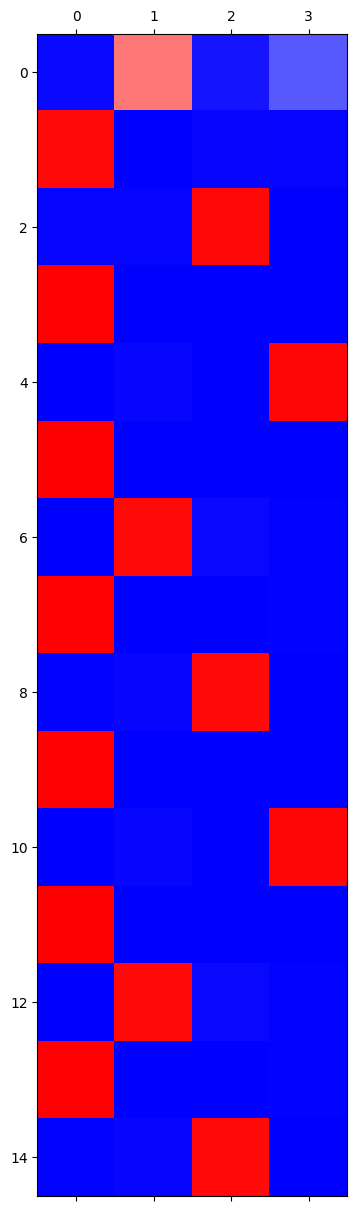

In [132]:
yhat = soft(output)

plt.matshow(yhat.data[:15].to('cpu'), cmap = 'bwr')

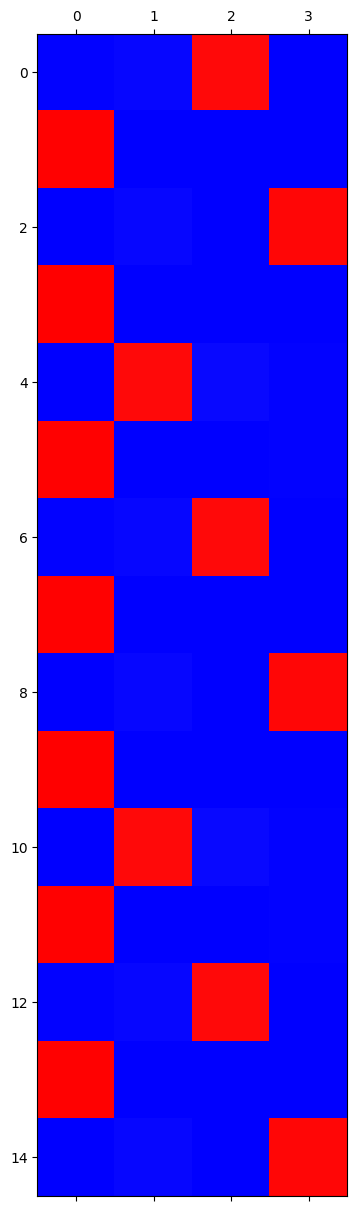

In [133]:
plt.matshow(yhat.data[-15:].to('cpu'), cmap = 'bwr')

- 히든 노드가 2개 였을 때는 초반에 틀렸지만 히든 노드가 3개 일때는 초반에도 다 맞추는 것을 확인할 수 있음

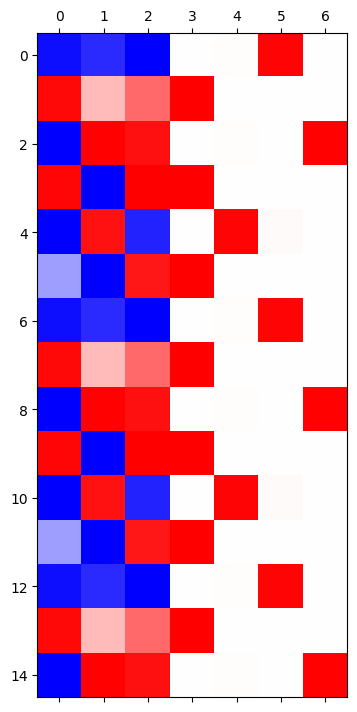

In [134]:
combined = torch.concat([hidden, yhat], axis = 1)
plt.matshow(combined[-15:].data.to('cpu'),cmap='bwr')

- 히든 층과 yhat을 시각화 한 것들을 보면 같은 A이지만 hidden에서는 다른 방식으로 설명을 하고 있는 것을 알 수 있다.  
`->` 즉 겉보기로는 같은 A이지만 사실은 다른 뜻의 A이므로 A1,b,A2,c,A3,d로 생각을 해야 함